In [1]:
from dataManager.RainDataManager import RainDataManager
from dataManager.TempDataManager import TempDataManager
from dataManager.BikeDataManager import BikeDataManager
from datetime import datetime, timedelta, date
import matplotlib.dates as mdates
from matplotlib import pylab as plt
import seaborn as sns

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
#!pip install --upgrade tf-nightly tfp-nightly

In [48]:
num_forecast_steps = 21

In [49]:
rainDM = RainDataManager()
tempDM = TempDataManager()
bikeDM = BikeDataManager()

In [50]:
tempDM.loadData()
bikeDM.loadData()
rainDM.loadData()

In [51]:
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [52]:
start_date = date(2017, 1, 1)
end_date = datetime.now().date()
dates = []
bikes = []
temps = []
rains = []
for single_date in daterange(start_date, end_date):
    #print(str(single_date) + ' --> ' + str(bikeDM.getDayValue(single_date)))
    #print(type(single_date))
    dates.append(single_date)
    bikes.append(np.float32(bikeDM.getDayValue(single_date)))
    temps.append(np.float32(tempDM.getDayValue(single_date)))
    rains.append(np.float32(rainDM.getDayValue(single_date)))
    

In [53]:
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

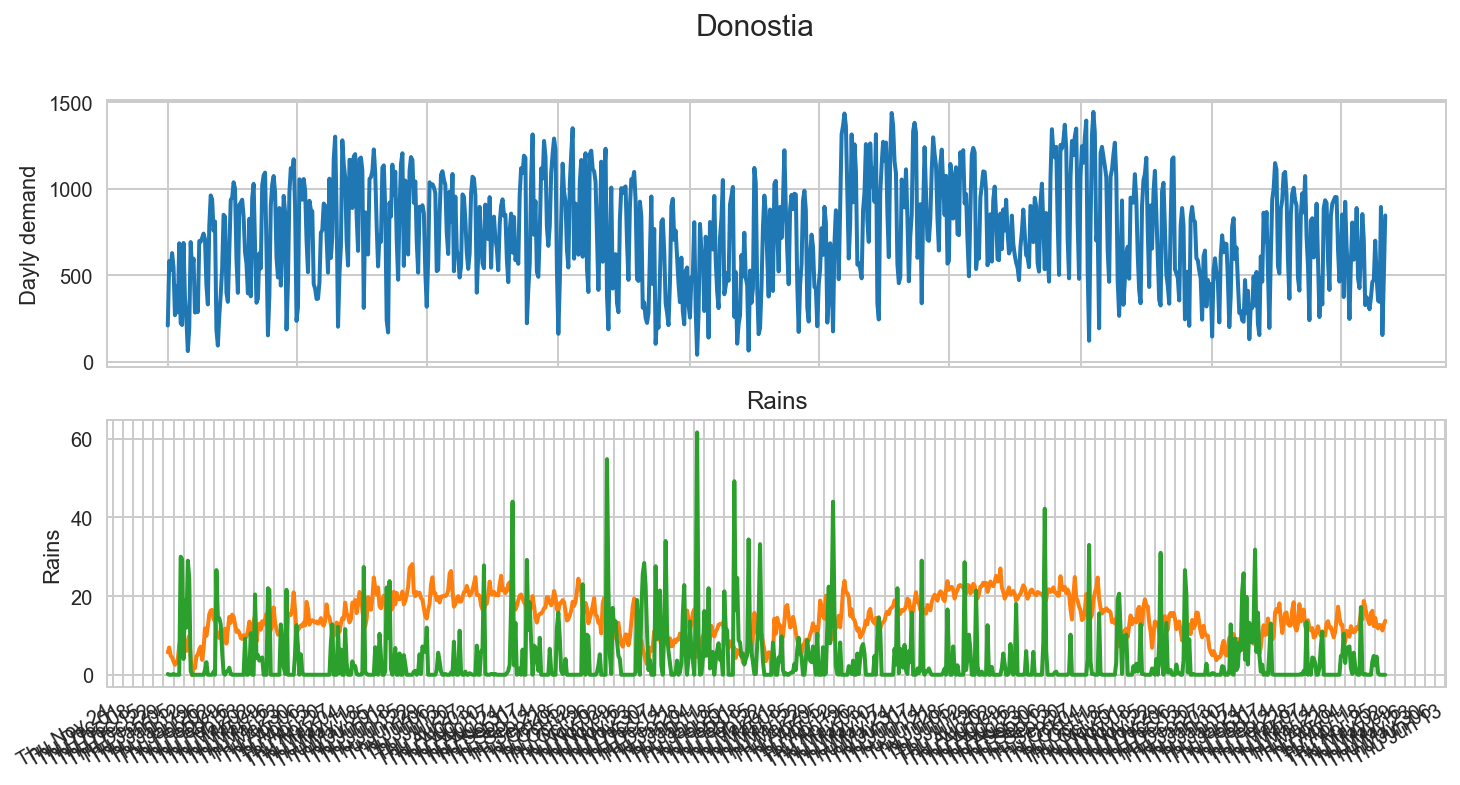

In [54]:
demand_loc = mdates.WeekdayLocator(3)
demand_fmt = mdates.DateFormatter('%a %b %d')

colors = sns.color_palette()
c1, c2, c3 = colors[0], colors[1], colors[2]

fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(2, 1, 1)
ax.plot(dates,
        bikes, lw=2, label="Full data")
ax.set_ylabel("Dayly demand")

ax = fig.add_subplot(2, 1, 2)
ax.plot(dates,
        temps, lw=2, label="Full data", c=c2)
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Temperature")

ax = fig.add_subplot(2, 1, 2)
ax.plot(dates,
        rains, lw=2, label="Full data", c=c3)
ax.set_ylabel("Rains")
ax.set_title("Rains")

ax.xaxis.set_major_locator(demand_loc)
ax.xaxis.set_major_formatter(demand_fmt)
fig.suptitle("Donostia",
             fontsize=15)
fig.autofmt_xdate()
plt.show()

fig.clear()
#plt.close(fig)

In [55]:
#Split data sets 
dates_train = dates[:-num_forecast_steps]
dates_test = dates[-num_forecast_steps:]

bikes_train = bikes[:-num_forecast_steps]
bikes_test = bikes[-num_forecast_steps:]

temps_train = temps[:-num_forecast_steps]
temps_test = temps[-num_forecast_steps:]

rains_train = rains[:-num_forecast_steps]
rains_test = rains[-num_forecast_steps:]


In [67]:
def build_model(valuesP, tempsP):
    trend = sts.LocalLinearTrend(observed_time_series=valuesP)
    seasonal = tfp.sts.Seasonal(
        num_seasons=7, observed_time_series=valuesP)
    
    seasonal2 = tfp.sts.Seasonal(
        num_seasons=30, observed_time_series=valuesP)
  
    seasonal3 = tfp.sts.Seasonal(
        num_seasons=365, observed_time_series=valuesP)
  
    temperature_effect = tfp.sts.LinearRegression(
        design_matrix=tf.reshape(temps - np.mean(temps),
        (-1, 1)), name='temperature_effect')
    
    rain_effect = tfp.sts.LinearRegression(
        design_matrix=tf.reshape(rains - np.mean(rains),
        (-1, 1)), name='rain_effect')

      
    autoregressive = tfp.sts.Autoregressive(
      order=1,
      observed_time_series=valuesP, name='autoregressive')
  
  
    model = sts.Sum([ seasonal, seasonal2, temperature_effect, rain_effect ], observed_time_series=valuesP)
    return model

In [69]:
tf.__version__

'1.13.1'

In [68]:
tf.reset_default_graph()
demand_model = build_model(bikes_train, temps_train)

# Build the variational loss function and surrogate posteriors `qs`.
with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
  elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
      demand_model, bikes_train)
train_vi = tf.train.AdamOptimizer(0.1).minimize(elbo_loss)

AttributeError: module 'tensorflow_probability.python.sts' has no attribute 'Autoregressive'

In [58]:
# Run the optimization and draw samples from the surrogate posteriors.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 301  # @param { isTemplate: true}
num_variational_steps = int(num_variational_steps)

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for i in range(num_variational_steps):
    _, elbo_ = sess.run((train_vi, elbo_loss))
    if i % 20 == 0:
      print("step {} -ELBO {}".format(i, elbo_))

  q_samples_demand_ = sess.run({k: q.sample(50)
                                for k, q in variational_posteriors.items()})

step 0 -ELBO 1963937.75
step 20 -ELBO 523584.9375
step 40 -ELBO 301377.0
step 60 -ELBO 224563.5
step 80 -ELBO 185291.21875
step 100 -ELBO 158627.203125
step 120 -ELBO 137707.796875
step 140 -ELBO 123632.6875
step 160 -ELBO 111750.484375
step 180 -ELBO 101856.9453125
step 200 -ELBO 94563.125
step 220 -ELBO 87370.078125
step 240 -ELBO 81776.8203125
step 260 -ELBO 76831.875
step 280 -ELBO 72751.25
step 300 -ELBO 68893.9375


In [59]:
print("Inferred parameters:")
for param in demand_model.parameters:
  print("{}: {} +- {}".format(param.name,
                              np.mean(q_samples_demand_[param.name], axis=0),
                              np.std(q_samples_demand_[param.name], axis=0)))

Inferred parameters:
observation_noise_scale: 7.261621475219727 +- 0.022585468366742134
Seasonal/_drift_scale: 7.89216423034668 +- 0.013289064168930054
Seasonal_1/_drift_scale: 7.944282054901123 +- 0.02271510846912861
temperature_effect/_weights: [10.22466] +- [0.02883271]
rain_effect/_weights: [-9.121363] +- [0.01023878]


In [60]:
demand_forecast_dist = tfp.sts.forecast(
    model=demand_model,
    observed_time_series=bikes_train,
    parameter_samples=q_samples_demand_,
    num_steps_forecast=num_forecast_steps)

In [61]:
num_samples=5

with tf.Session() as sess:
  (demand_forecast_mean,
   demand_forecast_scale,
   demand_forecast_samples) = sess.run(
      (demand_forecast_dist.mean()[..., 0],
       demand_forecast_dist.stddev()[..., 0],
       demand_forecast_dist.sample(num_samples)[..., 0]))

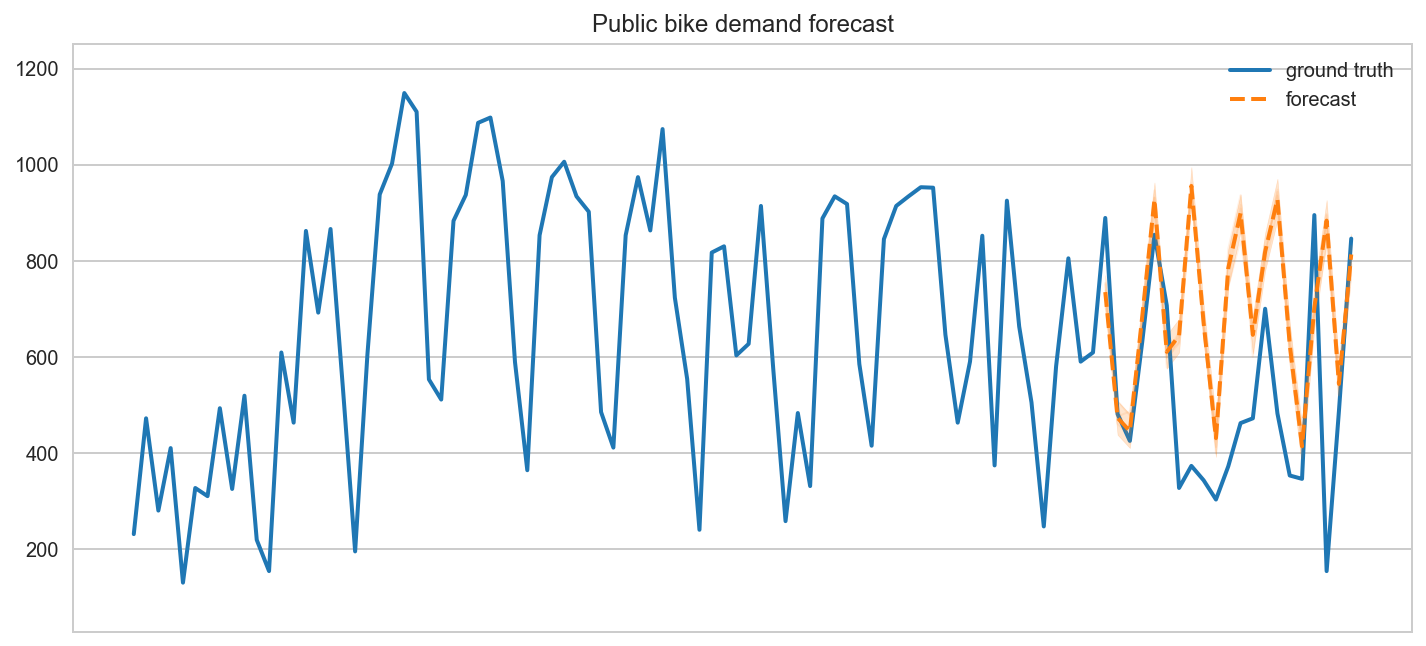

In [62]:
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast


    ax.plot( y, lw=2, color=c1, label='ground truth')

    forecast_steps = np.arange(
        num_steps_train,
        num_steps_train+num_steps_forecast)

    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

    ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2,
        label='forecast')
    ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax-ymin
    ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
    ax.set_title("{}".format(title))
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

    return fig, ax


fig, ax = plot_forecast(dates[-100:], bikes[-100:],
                        demand_forecast_mean,
                        demand_forecast_scale,
                        demand_forecast_samples,
                        title="Public bike demand forecast",
                        x_locator=demand_loc, x_formatter=demand_fmt)
#ax.set_ylim([0, 10])
plt.show()
